# Neural Network Optimization Techniques

In this assignment we will be build a multi layer neural network and train it to classify hand-written digits into 10 classes (digits 0-9). Assignment 3 will build upon the learning from Assignment 2. We will extend Assignment 2 by introducing optmization techniques like dropout, momentum and learning_rate scheduling and use of minibatch gradient descent

In [1]:
#import libraries and functions to load the data
from digits import get_mnist
from matplotlib import pyplot as plt
import numpy as np
import ast
import sys
import numpy.testing as npt
import pytest
import random
# from IPython.core.debugger import set_trace
import pickle

## Load and Visualize Data

MNIST dataset contains grayscale samples of handwritten digits of size 28 $\times$ 28. It is split into training set of 60,000 examples, and a test set of 10,000 examples. We will use the entire dataset for training. Since we plan to use minibatch gradient descent, we can work with a larger dataset and not worry if it will fit into memory. You will also see the improved speed of minibatch gradient descent compared to Assignment 2, where we used batch gradeint descent (using the entire training data as a batch).

trX.shape:  (784, 60000)
trY.shape:  (1, 60000)
tsX.shape:  (784, 10000)
tsY.shape:  (1, 10000)
Train max: value = 1.0, Train min: value = -1.0
Test max: value = 1.0, Test min: value = -1.0
Unique labels in train:  [0 1 2 3 4 5 6 7 8 9]
Unique labels in test:  [0 1 2 3 4 5 6 7 8 9]

Displaying a few samples
labels
[[5 0 4 1 9 2 1 3 1 4]
 [3 5 3 6 1 7 2 8 6 9]
 [4 0 9 1 1 2 4 3 2 7]
 [3 8 6 9 0 5 6 0 7 6]
 [1 8 7 9 3 9 8 5 9 3]
 [7 2 1 0 4 1 4 9 5 9]
 [0 6 9 0 1 5 9 7 3 4]
 [9 6 6 5 4 0 7 4 0 1]
 [3 1 3 4 7 2 7 1 2 1]
 [1 7 4 2 3 5 1 2 4 4]]


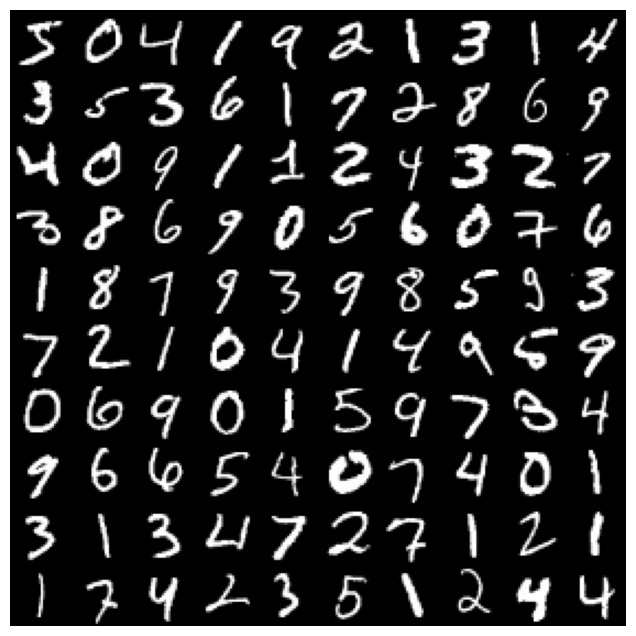

In [2]:
random.seed(1)
np.random.seed(1)
trX, trY, tsX, tsY = get_mnist()
# We need to reshape the data everytime to match the format (d,m), where d is dimensions (784) and m is number of samples
trX = trX.reshape(-1, 28*28).T
trY = trY.reshape(1, -1)
tsX = tsX.reshape(-1, 28*28).T
tsY = tsY.reshape(1, -1)
    
# Lets examine the data and see if it is normalized
print('trX.shape: ', trX.shape)
print('trY.shape: ', trY.shape)
print('tsX.shape: ', tsX.shape)
print('tsY.shape: ', tsY.shape)
print('Train max: value = {}, Train min: value = {}'.format(np.max(trX), np.min(trX)))
print('Test max: value = {}, Test min: value = {}'.format(np.max(tsX), np.min(tsX)))
print('Unique labels in train: ', np.unique(trY))
print('Unique labels in test: ', np.unique(tsY))

# Let's visualize a few samples and their labels from the train and test datasets.
print('\nDisplaying a few samples')
visx = np.concatenate((trX[:,:50],tsX[:,:50]), axis=1).reshape(28,28,10,10).transpose(2,0,3,1).reshape(28*10,-1)
visy = np.concatenate((trY[:,:50],tsY[:,:50]), axis=1).reshape(10,-1)
    
print('labels')
print(visy)
plt.figure(figsize = (8,8))
plt.axis('off')
plt.imshow(visx, cmap='gray')
plt.savefig('graph1.png')

## Reuse Code from Assignment 2

There are some sections in this assignment which require you to use the code you implemented for Assignment 2. These sections need to work correctly for Assignment 3 to be successful. However, these sections will not have any points assigned to them.

### Rectified Linear Unit-ReLU (repeated from Assignment 2:   0 points)

ReLU (Rectified Linear Unit) is a piecewise linear function defined as
\begin{equation*}
ReLU(Z) = \text{max}(0,Z)
\end{equation*}

Hint: use [numpy.maximum](https://docs.scipy.org/doc/numpy/reference/generated/numpy.maximum.html)

In [3]:
def relu(Z):
    '''
    Computes relu activation of input Z
    
    Inputs: 
        Z: numpy.ndarray (n, m) which represent 'm' samples each of 'n' dimension
        
    Outputs: 
        A: where A = ReLU(Z) is a numpy.ndarray (n, m) representing 'm' samples each of 'n' dimension
        cache: a dictionary with {"Z", Z}
        
    '''
    cache = {}
    # your code here
    A = np.maximum(0,Z)
    cache["Z"] = Z
    
    return A, cache

In [4]:
# Run this cell to test the above function
z_tst = [-2,-1,0,1,2]
a_tst, c_tst = relu(z_tst)
npt.assert_array_equal(a_tst,[0,0,0,1,2])
npt.assert_array_equal(c_tst["Z"], [-2,-1,0,1,2])

### ReLU - Gradient (repeated from Assignment 2:   0 points)

The gradient of ReLu($Z$) is 1 if $Z>0$ else it is 0.

In [5]:
def relu_der(dA, cache):
    '''
    Computes derivative of relu activation
    
    Inputs: 
        dA: derivative from the subsequent layer of dimension (n, m). 
            dA is multiplied elementwise with the gradient of ReLU
        cache: dictionary with {"Z", Z}, where Z was the input 
            to the activation layer during forward propagation
        
    Outputs: 
        dZ: the derivative of dimension (n,m). It is the elementwise 
            product of the derivative of ReLU and dA
        
    '''
    dZ = np.array(dA, copy=True)
    Z = cache["Z"]
    # your code here
    for row in range(Z.shape[0]):
        for col in range(Z.shape[1]):
            if Z[row][col] > 0:
                dZ[row][col] = dA[row][col]
            else:
                dZ[row][col] = 0
    return dZ

In [6]:
# Run this cell to test the above function
dA_tst = np.array([[0,2],[1,1]])
cache_tst = {}
cache_tst['Z'] = np.array([[-1,2],[1,-2]])
npt.assert_array_equal(relu_der(dA_tst,cache_tst),np.array([[0,2],[1,0]]))

### Linear activation and its derivative (repeated from Assignment 2)

There is no activation involved here. It is an identity function. 
\begin{equation*}
\text{Linear}(Z) = Z
\end{equation*}

In [7]:
def linear(Z):
    '''
    Computes linear activation of Z
    This function is implemented for completeness
        
    Inputs: 
        Z: numpy.ndarray (n, m) which represent 'm' samples each of 'n' dimension
        
    Outputs: 
        A: where A = Linear(Z) is a numpy.ndarray (n, m) representing 'm' samples each of 'n' dimension
        cache: a dictionary with {"Z", Z}   
    '''
    A = Z
    cache = {}
    cache["Z"] = Z
    return A, cache


def linear_der(dA, cache):
    '''
    Computes derivative of linear activation
    This function is implemented for completeness
    
    Inputs: 
        dA: derivative from the subsequent layer of dimension (n, m). 
            dA is multiplied elementwise with the gradient of Linear(.)
        cache: dictionary with {"Z", Z}, where Z was the input 
            to the activation layer during forward propagation
        
    Outputs: 
        dZ: the derivative of dimension (n,m). It is the elementwise 
            product of the derivative of Linear(.) and dA
    '''      
    dZ = np.array(dA, copy=True)
    return dZ

### Softmax Activation and Cross-entropy Loss Function (repeated from Assignment 2:  0 points)

The softmax activation is computed on the outputs from the last layer and the output label with the maximum probablity is predicted as class label. The softmax function can also be refered as normalized exponential function which takes a vector of $n$ real numbers as input, and normalizes it into a probability distribution consisting of $n$ probabilities proportional to the exponentials of the input numbers.

The input to the softmax function is the $(n \times m)$ matrix, $ Z = [ z^{(1)} , z^{(2)}, \ldots, z^{(m)} ] $, where $z^{(i)}$ is the $i^{th}$ sample of $n$ dimensions. We estimate the softmax for each of the samples $1$ to $m$. The softmax activation for sample $z^{(i)}$ is $a^{(i)} = \text{softmax}(z^{(i)})$, where the components of $a^{(i)}$ are,
\begin{equation}
a_k{(i)} = \frac{\text{exp}(z^{(i)}_k)}{\sum_{k = 1}^{n}\text{exp}(z^{(i)}_k)} \qquad \text{for} \quad 1\leq k\leq n
\end{equation}

The output of the softmax is $ A = [ a^{(1)} , a^{(2)} .... a^{(m)} ]$, where $a^{(i)} = [a^{(i)}_1,a^{(i)}_2, \ldots, a^{(i)}_n]^\top$.  In order to avoid floating point overflow, we subtract a constant from all the input components of $z^{(i)}$ before calculating the softmax. This constant is $z_{max}$, where, $z_{max} = \text{max}(z_1,z_2,...z_n)$. The activation is given by,

\begin{equation}
a_k{(i)} = \frac{\text{exp}(z^{(i)}_k- z_{max})}{\sum_{k = 1}^{n}\text{exp}(z^{(i)}_k - z_{max})} \qquad \text{for} \quad 1\leq k\leq n
\end{equation}

If the output of softmax is given by $A$ and the ground truth is given by $Y = [ y^{(1)} , y^{(2)}, \ldots, y^{(m)}]$, the cross entropy loss between the predictions $A$ and groundtruth labels $Y$ is given by,

\begin{equation}
Loss(A,Y) = - \frac{1}{m} \sum_{i=1}^m \sum_{k=1}^{n}I \{ y^i = k \} \text{log}a_k^i
\end{equation}


where $I$ is the identity function given by 

\begin{equation}
I\{\text{condition}\} = 1, \quad \text{if condition = True}\\
I\{\text{condition}\} = 0, \quad \text{if condition = False}\\
\end{equation}
Hint: use [numpy.exp](https://docs.scipy.org/doc/numpy/reference/generated/numpy.exp.html)
numpy.max,
[numpy.sum](https://docs.scipy.org/doc/numpy/reference/generated/numpy.sum.html)
[numpy.log](https://docs.scipy.org/doc/numpy/reference/generated/numpy.log.html)
Also refer to use of 'keepdims' and 'axis' parameter.

In [8]:
def softmax_cross_entropy_loss(Z, Y=np.array([])):
    '''
    Computes the softmax activation of the inputs Z
    Estimates the cross entropy loss

    Inputs: 
        Z: numpy.ndarray (n, m)
        Y: numpy.ndarray (1, m) of labels
            when y=[] loss is set to []
    
    Outputs:
        A: numpy.ndarray (n, m) of softmax activations
        cache: a dictionary to store the activations which will be used later to estimate derivatives
        loss: cost of prediction
    '''
    # your code here
    A = np.copy(Z)
    if (Y.size == 0):
        loss = []
    else:
        loss = 0
   
    m = Z.shape[1]
    
    for row in range(Z.shape[1]):
        exp_sum = np.sum(np.exp(Z[:,row]))
        for col in range(Z.shape[0]):
            A[col][row] = np.exp(Z[col][row]) / exp_sum
            if (Y.size != 0 and Y[0][row]==col):
                loss = loss + np.log(A[col][row])
    
    if (Y.size != 0):
        loss = -1/m * loss
    cache = {}
    cache["A"] = A
    return A, cache, loss

In [9]:
# Run this cell to test the above function
np.random.seed(1)
Z_t = np.random.randn(3,4)
Y_t = np.array([[1,0,1,2]])
A_t = np.array([[0.57495949, 0.38148818, 0.05547572, 0.36516899],
       [0.26917503, 0.07040735, 0.53857622, 0.49875847],
       [0.15586548, 0.54810447, 0.40594805, 0.13607254]])

A_est, cache_est, loss_est = softmax_cross_entropy_loss(Z_t, Y_t)
npt.assert_almost_equal(loss_est,1.2223655548779273,decimal=5)
npt.assert_array_almost_equal(A_est,A_t,decimal=5)
npt.assert_array_almost_equal(cache_est['A'],A_t,decimal=5)

### Derivative of the softmax_cross_entropy_loss(.) (repeated from Assignment 2   -   0 points)

We discused in the lecture that it is easier to directly estimate $dZ$ which is $\frac{dL}{dZ}$, where $Z$ is the input to the *softmax_cross_entropy_loss($Z$)* function. 

Let $Z$ be the $(n\times m)$ dimension input and $Y$ be the $(1,m)$ groundtruth labels. If $A$ is the $(n\times m)$ matrix of softmax activations of $Z$, the derivative $dZ$ is given by, 

\begin{equation}
dZ =\frac{1}{m} (A -\bar{Y})
\end{equation}

where, $\bar{Y}$ is the one-hot representation of $Y$. 

One-hot encoding is a binary representation of the discrete class labels. For example, let $y^{(i)}\in\{0,1,2\}$ for a 3-category problem. Assume there are $m=4$ data points. In this case $Z$ will be a $3 \times 4$ matrix. Let the categories of the 4 data points be $Y=[1,0,1,2]$. The one hot representation is given by, 
\begin{equation}
\bar{Y} = 
    \begin{bmatrix}
    0 ~ 1 ~ 0 ~ 0\\
    1 ~ 0 ~ 1 ~ 0\\
    0 ~ 0 ~ 0 ~ 1
    \end{bmatrix}
\end{equation}
where, the one-hot encoding for label $y^{(1)} = 1$ is $\bar{y}^{(1)} = [0, 1, 0]^\top$. Similarly, the one-hot encoding for $y^{(4)} = 2$ is $\bar{y}^{(4)} = [0, 0, 1]^\top$

In [10]:
def softmax_cross_entropy_loss_der(Y, cache):
    '''
    Computes the derivative of the softmax activation and cross entropy loss

    Inputs: 
        Y: numpy.ndarray (1, m) of labels
        cache: a dictionary with cached activations A of size (n,m)

    Outputs:
        dZ: derivative dL/dZ - a numpy.ndarray of dimensions (n, m) 
    '''
    A = cache["A"]
    # your code here
    dZ = np.copy(A)
    m = Y.shape[1]
    for row in range(A.shape[1]):
        for col in range(A.shape[0]):
            if (Y[0][row]==col):
                dZ[col][row]= 1/m * (A[col][row] - 1)
            else:
                dZ[col][row]= 1/m * A[col][row]
    return dZ

In [11]:
np.random.seed(1)
Z_t = np.random.randn(3,4)
Y_t = np.array([[1,0,1,2]])
A_t = np.array([[0.57495949, 0.38148818, 0.05547572, 0.36516899],
       [0.26917503, 0.07040735, 0.53857622, 0.49875847],
       [0.15586548, 0.54810447, 0.40594805, 0.13607254]])
cache_t={}
cache_t['A'] = A_t
dZ_t = np.array([[ 0.14373987, -0.15462795,  0.01386893,  0.09129225],
       [-0.18270624,  0.01760184, -0.11535594,  0.12468962],
       [ 0.03896637,  0.13702612,  0.10148701, -0.21598186]])

dZ_est = softmax_cross_entropy_loss_der(Y_t, cache_t)
npt.assert_almost_equal(dZ_est,dZ_t,decimal=5)

### Dropout forward (10 points)

The dropout layer is introduced to improve regularization by reducing overfitting. The layer will zero out some of the activations in the input based on the 'drop_prob' value. Dropout is only appiled in 'train' mode and not in 'test' mode. In the 'test' mode the output activations are the same as input activations. 
We will implement the inverted droput method we discussed in the lecture. We define 'prob_keep' as the percentage of activations remaining after dropout, if drop_out = 0.3, then prob_keep = 0.7, i.e., 70% of the activations are retained after dropout. 

In [12]:
def dropout(A, drop_prob, mode='train'):
        '''
        Using the 'inverted dropout' technique to implement dropout regularization.
        Inputs:
            A: Activation input before dropout is applied - shape is (n,m)
            drop_prob: dropout parameter. If drop_prob = 0.3, we drop 30% of the neuron activations
            mode: Dropout acts differently in training and testing mode. Hence, mode is a parameter which
                takes in only 2 values, 'train' or 'test'

        Outputs:
            A: Output of shape (n,m), with some values masked out and other values scaled to account for missing values
            cache: a tuple which stores the drop_prob, mode and mask for use in backward pass.
        '''
        # When there is no dropout return the same activation
        mask = None
        if drop_prob == 0:
            cache = (drop_prob, mode, mask)
            return A, cache
        
        # The prob_keep is the percentage of activations remaining after dropout
        # if drop_out = 0.3, then prob_keep = 0.7, i.e., 70% of the activations are retained
        prob_keep = 1-drop_prob
        
        # Note: instead of a binary mask implement a scaled mask, where mask is scaled by dividing it 
        # by the prob_keep for example, if we have input activations of size (3,4), then the mask is 
        # mask = (np.random.rand(3,4)<prob_keep)/prob_keep
        # We perform the scaling by prob_keep here so we don't have to do it specifically during backpropagation 
        # We then update A by multiplying it element wise with the mask
        
        if mode == 'train':
           # youre code here
            mask = (np.random.rand(A.shape[0],A.shape[1])<prob_keep)/prob_keep 
            A = np.multiply(A,mask)
            
        elif mode != 'test':
            raise ValueError("Mode value not set correctly, set it to 'train' or 'test'")
        cache = (drop_prob, mode, mask)
        return A, cache

In [13]:
np.random.seed(1)

x_t = np.random.rand(3,4)
drop_prob_t = 0.3
x_est, cache_est = dropout(x_t, drop_prob_t, mode='train')
npt.assert_array_almost_equal(x_est,np.array(
[[5.95745721e-01, 0.0, 1.63392596e-04, 4.31903675e-01],
 [2.09651273e-01, 1.31912278e-01, 2.66086016e-01, 4.93658181e-01],
 [0.0,            0.0,            5.98849306e-01, 9.78885001e-01]]
),5)
npt.assert_array_almost_equal(cache_est[2], np.array(
[[1.42857143, 0.,         1.42857143, 1.42857143],
 [1.42857143, 1.42857143, 1.42857143, 1.42857143],
 [0.,         0.,         1.42857143, 1.42857143]]
),5)
assert cache_est[1]=='train'
np.random.seed(1)
x_t = np.random.rand(3,4)
drop_prob_t = 0.3
out_est, cache_est = dropout(x_t, drop_prob_t, mode='test')
npt.assert_array_almost_equal(out_est, x_t, 6)
assert cache_est[1]=='test'
np.random.seed(1)
x_t = np.random.rand(3,4)
drop_prob_t = 0
out_est, cache_est = dropout(x_t, drop_prob_t, mode='train')
npt.assert_array_almost_equal(out_est, x_t, 6)
assert cache_est[0]==0
assert cache_est[1]=='train'
assert cache_est[2]==None

### Dropout backward (10 points)

In the backward pass, we estimate the derivative w.r.t. the dropout layer. We will need the 'drop_prob', 'mask' and 'mode' which is obtained from the cache saved during forward pass. 

In [14]:
def dropout_der(dA_in, cache):
        '''
        Backward pass for the inverted dropout.
        Inputs: 
            dA_in: derivative from the upper layers of dimension (n,m).
            cache: tuple containing (drop_out, mode, mask), where drop_out is the probability of drop_out, 
                if drop_out=0, then the layer does not have any dropout,
                mode is either 'train' or 'test' and 
                mask is a matirx of size (n,m) where 0's indicate masked values
        Outputs:
            dA_out = derivative of the dropout layer of dimension (n,m)
        '''
        
        dA_out = None
        drop_out, mode, mask = cache
        # If there is no dropout return the same derivative from the previous layer
        if not drop_out:
            return dA_in
        
        # if mode is 'train' dA_out is dA_in multiplied element wise by mask
        # if mode is 'test' dA_out is same as dA_in
        # your code here
        if mode == 'train':
            dA_out = np.multiply(dA_in,mask) 
        elif mode == 'test':
            dA_out = dA_in
        return dA_out

In [15]:
np.random.seed(1)
dA_in_t = np.random.rand(4,2)
mask_t = np.array(
[[1.42857143, 1.42857143],
 [1.42857143, 1.42857143],
 [1.42857143, 0.        ],
 [1.42857143, 1.42857143]])
mode_t = 'test'
drop_prob_t = 0.3
cache_t = (drop_prob_t,mode_t, mask_t)
dA_out_est = dropout_der(dA_in_t, cache_t)
npt.assert_array_almost_equal(dA_out_est, np.array(
[
 [4.17022005e-01, 7.20324493e-01],
 [1.14374817e-04, 3.02332573e-01],
 [1.46755891e-01, 9.23385948e-02],
 [1.86260211e-01, 3.45560727e-01]
]),6)

mode_t = 'train'
cache = (drop_prob_t, mode_t, mask_t)
dA_out_est = dropout_der(dA_in_t, cache)
npt.assert_almost_equal(dA_out_est,np.array(
[
 [5.95745721e-01, 1.02903499e+00],
 [1.63392596e-04, 4.31903675e-01],
 [2.09651273e-01, 0.0           ],
 [2.66086016e-01, 4.93658181e-01]
]),6)


### Batchnorm forward (15 points)

Batchnorm scales the input activations in a minibatch to have a specific mean and variance allowing the training to use larger learning rates to improve training speeds and provide more stability to the training. During training, the input minibatch is first normalized by making it zero mean and scaled to unit variance, i.e., ($0,I$) normalized. The normalized data is then converted to have a mean ($\beta$) and variance ($\gamma$), i.e., ($\beta,\gamma I$) normalized. Here, $\beta$ and $\gamma$ are the parameters for the batchnorm layer which are updated during training using gradient descent. 
The original batchnorm paper was implemented by applying batchnorm before nonlinear activation. However, batchnorm has been found to be more effective when applied after activation. We will implement this version in Assignment 3. 

In the lecture, we also discussed implementation of batchnorm during test mode when a single sample may be input for evaluation. We will not be implementing this aspect of batchnorm for the assignment. This implementation will work as designed only when a minibatch of data is presented to the network during evaluation (test mode) and may not work as expected when a single image is input for evaluation (test mode). 

The batchnorm implementation is tricky, especially the backpropagation. You may use the following source for reference: [Batchnorm backpropagation Tutorial](https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html). Note: The tutorial representes data as a $(m,n)$ matrix, whereas we represent data as a $(n,m)$ matrix, where $n$ is feature dimensions and $m$ is number of samples. 

If you are unable to implement the batchnorm correctly, you can still get the network to work by setting the variable 'bnorm_list = [0,0,...,0,0]. This is a list of binary varibles indicating if batchnorm is used for a layer (0 means no batchorm for the corresponding layer). This variable is used in the 'multi_layer_network(.)' function when initalizing the network. 
Although the follwing testcases may fail, the network can still work without batchnorm and you can get partial credit. 

The variables you save into the cache is your choice. The tescase only tests for the normalized output.

In [16]:
def batchnorm(A, beta, gamma):
    '''
    Batchnorm normalizes the input A to mean beta and standard deviation gamma
    
    Inputs: 
        A: Activation input after activation - shape is (n,m), m samples where each sample x is (n,1)
        beta: mean vector which will be the center of the data after batchnorm - shape is (n,1)
        gamma: standard deviation vector which will be scale of the data after batchnorm - shape (n,1)
        
    Outputs: 
        Anorm: Normalized version of input A - shape (n,m)
        cache: Dictionary of the elements that are necessary for backpropagation
    '''
    
    # When there is no batch norm for a layer, the beta and gamma will be empty arrays
    if beta.size == 0 or gamma.size == 0:
        cache = {}
        return A, cache
    # epsilon value used for scaling during normalization to avoid divide by zero. 
    # don't change this value - the test case will fail if you change this value
    epsilon = 1e-5
    # your code here
    N, D = A.shape
    
    mean = A.mean(axis=1) 
    var = A.var(axis=1)    
    std = np.sqrt(var + epsilon) 
    ivar = 1 / std.reshape(N,1)
    cen = A - mean.reshape(N,1) 
    norm = cen / std.reshape(N,1) 
    Anorm = gamma * norm + beta
    cache = (norm,gamma,cen,ivar,std.reshape(N,1),var.reshape(N,1), epsilon)

    return Anorm, cache

In [17]:
A_t = np.array([[1., 2.],[3., 4.],[5., 6]])
beta_t = np.array([[1.], [2.], [3.]])
gamma_t = np.array([[4.], [5.], [6.]])
Anorm_est, cache_est = batchnorm(A_t, beta_t, gamma_t)
npt.assert_array_almost_equal(Anorm_est,np.array(
[
 [-2.99992,  4.99992],
 [-2.9999,   6.9999 ],
 [-2.99988,  8.99988]
]),5)


### Batchnorm backward (15 points)

The forward propagation for batchnorm is relatively straightfoward to implement. For the backward propagation to worrk, you will need to save a set of variables in the cache during the forward propagation. The variables in your cache are your choice. The testcase only tests for the derivative.

In [18]:
def batchnorm_der(dA_in, cache):
    '''
    Derivative of the batchnorm
    Inputs: 
        dA_in: derivative from the upper layers of dimension (n,m).
        cache: Dictionary of the elements that are necessary for backpropagation
    Outputs:
        dA_out: derivative of the batchnorm layer of dimension (n,m)
        dbeta: derivative of beta - shape (n,1)
        dgamma: derivative of gamma - shape (n,1)
    '''
    # When the cache is empty, it indicates there was no batchnorm for the layer
    if not cache:
        dbeta = []
        dgamma = []
        return dA_in, dbeta, dgamma
    
    # your code here
    xhat,gamma,xmu,ivar,sqrtvar,var,eps = cache 
    D,N = dA_in.shape
    
    dgamma = (dA_in * xhat).sum(axis = 1).reshape(D,1) 
    dbeta = dA_in.sum(axis = 1).reshape(D,1)
    dx_norm = dA_in * gamma
    dA_out = 1/N / sqrtvar * (N * dx_norm - dx_norm.sum(axis = 1).reshape(D,1) - xhat * (dx_norm * xhat).sum(axis = 1).reshape(D,1))
    return dA_out, dbeta, dgamma

In [19]:
A_t = np.array([[1., 2.],[3., 4.],[5., 6]])
beta_t = np.array([[1.], [2.], [3.]])
gamma_t = np.array([[4.], [5.], [6.]])
Anorm_t, cache_t = batchnorm(A_t, beta_t, gamma_t)
dA_in_t = np.array(
[
  [4.,  5.],
  [8.,  10.],
  [12., 15.]
])
dA_out_est, dbeta_est, dgamma_est = batchnorm_der(dA_in_t, cache_t)
npt.assert_array_almost_equal(dA_out_est,np.array(
[
 [ -0.0001600,    0.0001600],
 [ -0.0004000,    0.0004000],
 [ -0.0007200,    0.0007200]
]),5)
npt.assert_array_almost_equal(dbeta_est,np.array([[9.],[18.],[27.]]),5)
npt.assert_array_almost_equal(dgamma_est,np.array([[1.],[2.],[3.]]),4)

### Parameter Initialization (5 points)

We will define the function to initialize the parameters of the multi-layer neural network.
The network parameters will be stored as dictionary elements that can easily be passed as function parameters while calculating gradients during back propogation.

The parameters are initialized using Kaiming He Initialization (discussed in the lecture). For example, a layer with weights of dimensions $(n_{out}, n_{in})$, the parameters are initialized as
$w = np.random.randn(n_{out},n_{in})*(2./np.sqrt(n_{in}))$ and 
$b = np.zeros((n_{out},1))$

The dimension for weight matrix for layer $(l+1)$ is given by ( Number-of-neurons-in-layer-$(l+1)$   $\times$   Number-of-neurons-in-layer-$l$ ). The dimension of the bias for for layer $(l+1)$ is (Number-of-neurons-in-layer-$(l+1)$   $\times$   1)

In [20]:
def initialize_network(net_dims, act_list, drop_prob_list):
    '''
    Initializes the parameters W's and b's of a multi-layer neural network
    Adds information about dropout and activations in each layer
    
    Inputs:
        net_dims: List containing the dimensions of the network. The values of the array represent the number of nodes in 
        each layer. For Example, if a Neural network contains 784 nodes in the input layer, 800 in the first hidden layer, 
        500 in the secound hidden layer and 10 in the output layer, then net_dims = [784,800,500,10]. 
        act_list: list of strings indicating the activation for a layer
        drop_prob_list: list of dropout probabilities for each layer 
    
    Outputs:
        parameters: dictionary of 
                    {"numLayers":..}
                    activations, {"act1":"..", "act2":"..", ...}
                    dropouts, {"dropout1": .. , "dropout2": .., ...}
                    network parameters, {"W1":[..],"b1":[..],"W2":[..],"b2":[..],...}
            The weights are initialized using Kaiming He et al. Initialization
    '''
    net_dims_len = len(net_dims)
    parameters = {}
    parameters['numLayers'] = net_dims_len - 1;
    for l in range(net_dims_len-1):
        parameters["act"+str(l+1)] = act_list[l]
        parameters["dropout"+str(l+1)] = drop_prob_list[l]
        # Note: Use He et al. Initialization to initialize W and set bias to 0's
        # parameters["W"+str(l+1)] = 
        # parameters["b"+str(l+1)] =
        # your code here
        Wpart = np.random.randn(net_dims[l+1],net_dims[l])
        parameters["W"+str(l+1)] = Wpart * (2./np.sqrt(net_dims[l]))
        parameters["b"+str(l+1)] = np.zeros((net_dims[l+1],1))
    return parameters

In [21]:
np.random.seed(1)
net_dims_t = [3,4,1]
act_list_t = ['relu', 'linear']
drop_prob_list = [0.3,0.5]
parameters_est = initialize_network(net_dims_t, act_list_t, drop_prob_list)
npt.assert_array_almost_equal(parameters_est['W1'], [
 [ 1.87563247, -0.70639546, -0.60988021],
 [-1.23895745,  0.99928666, -2.65758797],
 [ 2.01473508, -0.87896602,  0.36839462],
 [-0.28794811,  1.68829682, -2.37884559]
],6)
assert parameters_est['W1'].shape == (4,3)
assert parameters_est['W2'].shape == (1,4)
assert parameters_est['b1'].shape == (4,1)
assert parameters_est['b2'].shape == (1,1)
assert parameters_est['b1'].all() == 0
assert parameters_est['b2'].all() == 0
assert parameters_est['act1'] == 'relu'
assert parameters_est['act2'] == 'linear'
assert parameters_est['dropout1'] == 0.3
assert parameters_est['dropout2'] == 0.5

### Adam (momentum) Parameters - Velocity and Gradient-Squares Initialization (5 points)

We will optmize using Adam (momentum). This requires velocity parameters $V$ and Gradient-Squares parameters $G$. Here is a quick recap of Adam optmization, 

\begin{equation} 
V_{t+1} = \beta V_{t} +(1-\beta)\nabla J(\theta_t)\\ 
G_{t+1} = \beta_2 G_{t} +(1-\beta_2)\nabla J(\theta_t)^2\\ 
\theta_{t+1} =\theta_{t} -\frac{\alpha}{\sqrt{G_{t+1}+\epsilon}}V_{t+1}, \quad \theta \in \{ W,b \} 
\end{equation}

Parameters $V$ are the momentum velocity parameters and parameters $G$ are the Gradient-Squares. 
$\nabla J(\theta)$ is the gradient term $dW$ or $db$, and $\nabla  J(\theta)^2$ is the element wise square of the gradient. 
$\alpha$ is the step_size for gradient descent. It is has been estimated by decaying the 'learning_rate' based on 'decay_rat'e and 'epoch' number. $\beta$, $\beta_2$ and $\epsilon$ are constants which we will set up later.

Each of the parameters $W$'s and $b$'s for all the layers will have their corresponding velocity ($V$) and Gradient-Squares ($G$) parameters. The following function will initialize $V$ and $G$ to zeros with the same size as the corresponding parameters. 

In [22]:
def initialize_velocity(parameters, apply_momentum=True):
    '''
    The function will add Adam momentum parameters, Velocity and Gradient-Squares 
    to the parameters for each of the W's and b's 
    
    Inputs: 
        parameters: dictionary containing, 
                    {"numLayers":..}
                    activations, {"act1":"..", "act2":"..", ...}
                    dropouts, {"dropout1": .. , "dropout2": .., ...}
                    network parameters, {"W1":[..],"b1":[..],"W2":[..],"b2":[..],...}
                    Note: It is just one dictionary (parameters) with all these key value pairs, not multiple dictionaries
        apply_momentum: boolean on whether to apply momentum
        
    Outputs:
        parameters: dictionary that has been updated to include velocity and Gradient-Squares. It now contains,
                    {"numLayers":..}
                    activations, {"act1":"..", "act2":"..", ...}
                    dropouts, {"dropout1": .. , "dropout2": .., ...}
                    {"apply_momentum":..}
                    velocity parameters, {"VdW1":[..],"Vdb1":[..],"VdW2":[..],"Vdb2":[..],...}
                    Gradient-Squares parameters, {"GdW1":[..],"Gdb1":[..],"GdW2":[..],"Gdb2":[..],...}
                    Note: It is just one dictionary (parameters) with all these key value pairs, not multiple dictionaries
    '''
    
    L = parameters['numLayers'] 
    parameters['apply_momentum'] = apply_momentum
    
    # Initialize Velocity and the Gradient-Squares to zeros the same size as the corresponding parameters W's abd b's
    for l in range(L):
        if apply_momentum:
            # Hint: Velocity parameters are represented as VdW and Vdb
            #      Gradient-Squares are represented as GdW and Gdb
            # You can use np.zeros_like(.) to initilaize them 0's the same size as corresponding parameters W and b
            # parameters["VdW" + str(l+1)] = 
            # parameters["Vdb" + str(l+1)] =
            # parameters["GdW" + str(l+1)] =
            # parameters["Gdb" + str(l+1)] =
            # your code here
            parameters["VdW" + str(l+1)] = np.zeros_like(parameters['W'+ str(l+1)])
            parameters["Vdb" + str(l+1)] = np.zeros_like(parameters['b'+ str(l+1)])
            parameters["GdW" + str(l+1)] = np.zeros_like(parameters["VdW" + str(l+1)])
            parameters["Gdb" + str(l+1)] = np.zeros_like(parameters["Vdb" + str(l+1)])
    return parameters

In [23]:
net_dims_t = [5,4,1]
act_list_t = ['relu', 'linear']
drop_prob_list = [0.3,0.5]
parameters_t = initialize_network(net_dims_t, act_list_t, drop_prob_list)
parameters_t = initialize_velocity(parameters_t)
assert parameters_t['VdW1'].shape == (4,5)
assert parameters_t['VdW1'].all() == 0
assert parameters_t['VdW2'].shape == (1,4)
assert parameters_t['VdW2'].all() == 0
assert parameters_t['Vdb1'].shape == (4,1)
assert parameters_t['Vdb2'].shape == (1,1) 
assert parameters_t['Vdb1'].all() == 0
assert parameters_t['Vdb2'].all() == 0
assert parameters_t['GdW1'].shape == (4,5)
assert parameters_t['GdW1'].all() == 0
assert parameters_t['GdW2'].shape == (1,4)
assert parameters_t['GdW2'].all() == 0
assert parameters_t['Gdb1'].shape == (4,1)
assert parameters_t['Gdb2'].shape == (1,1)
assert parameters_t['Gdb1'].all() == 0
assert parameters_t['Gdb2'].all() == 0
assert parameters_t['apply_momentum'] == True

### Batchnorm Parameters and corresponding Velocity and Gradient-Squares Initialization 

In [24]:
def initialize_bnorm_params(parameters, bnorm_list, apply_momentum):
    '''
    The function will add batchnorm parameters beta's and gamma's and their corresponding
    Velocity and Gradient-Squares to the parameters dictionary
    
    Inputs: 
        parameters: dictionary that contains,
                    {"numLayers":..}
                    activations, {"act1":"..", "act2":"..", ...}
                    dropouts, {"dropout1": .. , "dropout2": .., ...}
                    {"apply_momentum":..}
                    velocity parameters, {"VdW1":[..],"Vdb1":[..],"VdW2":[..],"Vdb2":[..],...}
                    Gradient-Squares parameters, {"GdW1":[..],"Gdb1":[..],"GdW2":[..],"Gdb2":[..],...}
                    Note: It is just one dictionary (parameters) with all these key value pairs, not multiple dictionaries
        bnorm_list: binary list indicating if batchnorm should be implemented for a layer
        apply_momentum: boolean on whether to apply momentum
        
    Outputs:
        parameters: dictionary that has been updated to include batchnorm parameters, beta, gamma 
                    and their corresponding momentum parameters. It now contains,
                    {"numLayers":..}
                    activations, {"act1":"..", "act2":"..", ...}
                    dropouts, {"dropout1": .. , "dropout2": .., ...}
                    velocity parameters, {"VdW1":[..],"Vdb1":[..],"VdW2":[..],"Vdb2":[..],...}
                    Gradient-Squares parameters, {"GdW1":[..],"Gdb1":[..],"GdW2":[..],"Gdb2":[..],...}
                    {"bnorm_list":..}
                    batchnorm parameters, {"bnorm_beta1":[..],"bnorm_gamma1":[..],"bnorm_beta2":[..],"bnorm_gamma2":[..],...}
                    batchnorm velocity parameters, {"Vbnorm_beta1":[..],"Vbnorm_gamma1":[..],"Vbnorm_beta2":[..],"Vbnorm_gamma2":[..],...}
                    batchnorm Gradient-Square parameters, {"Gbnorm_beta1":[..],"Gbnorm_gamma1":[..],"Gbnorm_beta2":[..],"Gbnorm_gamma2":[..],...}
                    Note: It is just one dictionary (parameters) with all these key value pairs, not multiple dictionaries
    '''
    
    L = parameters['numLayers']
    parameters['bnorm_list'] = bnorm_list
    
    # Initialize batchnorm parameters for the hidden layers only. 
    # Each hidden layer will have a dictionary of parameters, beta and gamma based on the dimensions of the hidden layer. 
    for l in range(L):
        if bnorm_list[l]:
            n = parameters["W" + str(l+1)].shape[0]
            parameters['bnorm_beta'+str(l+1)] = np.random.randn(n,1)
            parameters['bnorm_gamma'+str(l+1)] = np.random.randn(n,1)
            if apply_momentum:
                parameters['Vbnorm_beta'+str(l+1)] = np.zeros((n,1))
                parameters['Gbnorm_beta'+str(l+1)] = np.zeros((n,1))
                parameters['Vbnorm_gamma'+str(l+1)] = np.zeros((n,1))
                parameters['Gbnorm_gamma'+str(l+1)] = np.zeros((n,1))
        else:
            parameters['bnorm_beta'+str(l+1)] = np.asarray([])
            parameters['Vbnorm_beta'+str(l+1)] = np.asarray([])
            parameters['Gbnorm_beta'+str(l+1)] = np.asarray([])
            parameters['bnorm_gamma'+str(l+1)] = np.asarray([])
            parameters['Vbnorm_gamma'+str(l+1)] = np.asarray([])
            parameters['Gbnorm_gamma'+str(l+1)] = np.asarray([])
    return parameters

### Forward Propagation Through a Single Layer (repeated from Assignment 2 - 0 points)

If the vectorized input to any layer of neural network is $A\_prev$ and the parameters of the layer are given by $(W,b)$, the output of the layer (before the activation is):
\begin{equation}
Z = W.A\_prev + b
\end{equation}

In [25]:
def linear_forward(A_prev, W, b):
    '''
    Input A_prev propagates through the layer 
    Z = WA + b is the output of this layer. 

    Inputs: 
        A_prev: numpy.ndarray (n,m) the input to the layer
        W: numpy.ndarray (n_out, n) the weights of the layer
        b: numpy.ndarray (n_out, 1) the bias of the layer

    Outputs:
        Z: where Z = W.A_prev + b, where Z is the numpy.ndarray (n_out, m) dimensions
        cache: a dictionary containing the inputs A
    '''
    # your code here
    Z=np.dot(W,A_prev)+b
    
    cache = {}
    cache["A"] = A_prev
    return Z, cache

In [26]:
np.random.seed(1)
n1 = 3
m1 = 4
A_prev_t = np.random.randn(n1,m1)
W_t = np.random.randn(n1, n1)
b_t = np.random.randn(n1, 1)
Z_est, cache_est = linear_forward(A_prev_t, W_t, b_t)

### Forward Propagation Through a Layer (linear $\rightarrow$ activation $\rightarrow$ batchnorm $\rightarrow$ dropout)

The input to the layer propagates through the layer in the order linear $\rightarrow$ activation $\rightarrow$ batchnorm $\rightarrow$ dropout saving different cache along the way.

In [27]:
def layer_forward(A_prev, W, b, activation, drop_prob, bnorm_beta, bnorm_gamma, mode):
    '''
    Input A_prev propagates through the layer followed by activation, batchnorm and dropout

    Inputs: 
        A_prev: numpy.ndarray (n,m) the input to the layer
        W: numpy.ndarray (n_out, n) the weights of the layer
        b: numpy.ndarray (n_out, 1) the bias of the layer
        activation: is the string that specifies the activation function
        drop_prob: dropout parameter. If drop_prob = 0.3, we drop 30% of the neuron activations
        bnorm_beta: batchnorm beta 
        bnorm_gamma: batchnorm gamma
        mode: 'train' or 'test' Dropout acts differently in training and testing mode. Hence, mode is a parameter which
                takes in only 2 values, 'train' or 'test'

    Outputs:
        A: = g(Z), where Z = WA + b, where Z is the numpy.ndarray (n_out, m) dimensions
        g is the activation function
        cache: a dictionary containing the cache from the linear propagation, activation, bacthnorm and dropout
        to be used for derivative
    '''
    
    Z, lin_cache = linear_forward(A_prev, W, b)
    if activation == "relu":
        A, act_cache = relu(Z)
    elif activation == "linear":
        A, act_cache = linear(Z)
    
    A, bnorm_cache = batchnorm(A, bnorm_beta, bnorm_gamma)
    A, drop_cache = dropout(A, drop_prob, mode)
    cache = {}
    cache["lin_cache"] = lin_cache
    cache["act_cache"] = act_cache
    cache["bnorm_cache"] = bnorm_cache
    cache["drop_cache"] = drop_cache
    
    return A, cache

### Multi-Layers Forward Propagation

Starting with the input 'A0' and the first layer of the network, we will propgate A0 through every layer using the output of the previous layer as input to the next layer. we will gather the caches from every layer in a list and use it later for backpropagation. We will use the 'layer_forward(.)' function to get the output and caches for a layer. 

In [28]:
def multi_layer_forward(A0, parameters, mode):
    '''
    Forward propgation through the layers of the network

    Inputs: 
        A0: numpy.ndarray (n,m) with n features and m samples
        parameters: dictionary of network parameters {"W1":[..],"b1":[..],"W2":[..],"b2":[..]...}
        mode: 'train' or 'test' Dropout acts differently in training and testing mode. Hence, mode is a parameter which
                takes in only 2 values, 'train' or 'test' 
    
    Outputs:
        AL: numpy.ndarray (c,m)  - outputs of the last fully connected layer before softmax
            where c is number of categories and m is number of samples
        caches: a list of caches from every layer after forward propagation
    '''
    
    L = parameters['numLayers']
    A = A0
    caches = []
    for l in range(L):
        A, cache = layer_forward(A, parameters["W"+str(l+1)], parameters["b"+str(l+1)], \
                                 parameters["act"+str(l+1)], parameters["dropout"+str(l+1)], \
                                 parameters['bnorm_beta'+str(l+1)], parameters['bnorm_gamma'+str(l+1)], mode)
        caches.append(cache)
    return A, caches

### Backward Propagagtion for the Linear Computation of a Layer (repeated from Assignment 2 - 0 points)

Consider the linear layer $Z = W.A\_prev + b$. We would like to estimate the gradients $\frac{dL}{dW}$ - represented as $dW$, $\frac{dL}{db}$ - represented as $db$ and $\frac{dL}{dA\_prev}$ - represented as $dA\_prev$. 
The input to estimate these derivatives is $\frac{dL}{dZ}$ - represented as $dZ$. The derivatives are given by, 

\begin{equation}
dA\_prev = W^T dZ\\
dW = dZ A^T\\
db = \sum_{i=1}^{m} dZ^{(i)}\\
\end{equation}

where $dZ = [dz^{(1)},dz^{(2)}, \ldots, dz^{(m)}]$ is $(n \times m)$ matrix of derivatives. 
The figure below represents a case fo binary cassification where $dZ$ is of dimensions $(1 \times m)$. The example can be extended to $(n\times m)$. 

In [29]:
def linear_backward(dZ, cache, W, b):
    '''
    Backward prpagation through the linear layer

    Inputs:
        dZ: numpy.ndarray (n,m) derivative dL/dz 
        cache: a dictionary containing the inputs A, for the linear layer
            where Z = WA + b,    
            Z is (n,m); W is (n,p); A is (p,m); b is (n,1)
        W: numpy.ndarray (n,p)
        b: numpy.ndarray (n,1)

    Outputs:
        dA_prev: numpy.ndarray (p,m) the derivative to the previous layer
        dW: numpy.ndarray (n,p) the gradient of W 
        db: numpy.ndarray (n,1) the gradient of b
    '''
    
    A = cache["A"]
    # your code here
    dA_prev=np.dot(np.transpose(W),dZ) 
    dW=np.dot(dZ,np.transpose(A)) 
    db=np.sum(dZ,axis=1) 
    db=np.transpose(db) 
    db=db.reshape((b.shape[0],1))

    return dA_prev, dW, db

In [30]:
np.random.seed(1)
n1 = 3
m1 = 4
p1 = 5
dZ_t = np.random.randn(n1,m1)
A_t = np.random.randn(p1,m1)
cache_t = {}
cache_t['A'] = A_t
W_t = np.random.randn(n1,p1)
b_t = np.random.randn(n1,1)

dA_prev_est, dW_est, db_est = linear_backward(dZ_t, cache_t, W_t, b_t)

### Back Propagation Through a Layer (dropout $\rightarrow$ batchnorm $\rightarrow$ activation $\rightarrow$ linear)

We will define the backpropagation for a layer. We will use the backpropagation for the dropout, followed by backpropagation for batchnorm, backpropagation of activation and backpropagation of a linear layer, in that order. This is the reverse order to the forward propagation.

In [31]:
def layer_backward(dA, cache, W, b, activation):
    '''
    Backward propagation through the activation and linear layer

    Inputs:
        dA: numpy.ndarray (n,m) the derivative to the previous layer
        cache: dictionary containing the linear_cache and the activation_cache
        W: numpy.ndarray (n,p)
        b: numpy.ndarray (n,1)
        activation: activation of the layer, 'relu' or 'linear'
    
    Outputs:
        dA_prev: numpy.ndarray (p,m) the derivative to the previous layer
        dW: numpy.ndarray (n,p) the gradient of W 
        db: numpy.ndarray (n,1) the gradient of b
        dbnorm_beta: numpy.ndarray (n,1) derivative of beta for the batchnorm layer
        dbnorm_gamma: numpy.ndarray (n,1) derivative of gamma for the batchnorm layer
    '''

    lin_cache = cache["lin_cache"]
    act_cache = cache["act_cache"]
    drop_cache = cache["drop_cache"]
    bnorm_cache = cache["bnorm_cache"]
    
    dA = dropout_der(dA, drop_cache)
    dA, dbnorm_beta, dbnorm_gamma = batchnorm_der(dA, cache["bnorm_cache"])
    if activation == "relu":
        dZ = relu_der(dA, act_cache)
    elif activation == "linear":
        dZ = linear_der(dA, act_cache)
        
    dA_prev, dW, db = linear_backward(dZ, lin_cache, W, b)
    return dA_prev, dW, db, dbnorm_beta, dbnorm_gamma

### Multi-layers Back Propagation

We have defined the required functions to handle back propagation for a single layer. Now we will stack the layers together and perform back propagation on the entire network starting with the final layer. We will need teh caches stored during forward propagation. 

In [32]:
def multi_layer_backward(dAL, caches, parameters):
    '''
    Back propgation through the layers of the network (except softmax cross entropy)
    softmax_cross_entropy can be handled separately

    Inputs: 
        dAL: numpy.ndarray (n,m) derivatives from the softmax_cross_entropy layer
        caches: a dictionary of associated caches of parameters and network inputs
        parameters: dictionary of network parameters {"W1":[..],"b1":[..],"W2":[..],"b2":[..]...}

    Outputs:
        gradients: dictionary of gradient of network parameters 
            {"dW1":[..],"db1":[..],"dW2":[..],"db2":[..],...\
            "dbnorm_beta1":[..],"dbnorm_gamma1":[..],"dbnorm_beta2":[..],"dbnorm_gamma2":[..],...}
    '''

    L = len(caches) 
    gradients = {}
    dA = dAL
    activation = "linear"
    for l in reversed(range(L)):
        dA, gradients["dW"+str(l+1)], gradients["db"+str(l+1)], \
        gradients["dbnorm_beta"+str(l+1)], gradients["dbnorm_gamma"+str(l+1)] \
                    = layer_backward(dA, caches[l], parameters["W"+str(l+1)],\
                                     parameters["b"+str(l+1)],parameters["act"+str(l+1)])
    return gradients

### Parameter Update Using Adam (momentum) (15 points)

The parameter gradients $(dW,db)$ calculated during back propagation are used to update the values of the network parameters using Adam optmization which is the momentum technique we discussed in the lecture.

\begin{equation} 
V_{t+1} = \beta V_{t} +(1-\beta)\nabla J(\theta_t)\\ 
G_{t+1} = \beta_2 G_{t} +(1-\beta_2)\nabla J(\theta_t)^2\\ 
\theta_{t+1} =\theta_{t} -\frac{\alpha}{\sqrt{G_{t+1}+\epsilon}}V_{t+1}, \quad \theta \in \{ W,b \} 
\end{equation}

Parameters $V$ are the momentum velocity parameters and parameters $G$ are the Gradient-Squares. 
$\nabla J(\theta)$ is the gradient term $dW$ or $db$, and $\nabla  J(\theta)^2$ is the element wise square of the gradient. 
$\alpha$ is the step_size for gradient descent. It is has been estimated by decaying the learning_rate based on decay_rate and epoch number. 

In [33]:
def update_parameters_with_momentum_Adam(parameters, gradients, alpha, beta=0.9, beta2=0.99, eps=1e-8):
    '''
    Updates the network parameters with gradient descent

    Inputs:
        parameters: dictionary of 
                    network parameters, {"W1":[..],"b1":[..],"W2":[..],"b2":[..],...}
                    velocity parameters, {"VdW1":[..],"Vdb1":[..],"VdW2":[..],"Vdb2":[..],...}
                    Gradient-Squares parameters, {"GdW1":[..],"Gdb1":[..],"GdW2":[..],"Gdb2":[..],...}
                    batchnorm parameters, {"bnorm_beta1":[..],"bnorm_gamma1":[..],"bnorm_beta2":[..],"bnorm_gamma2":[..],...}
                    batchnorm velocity parameters, {"Vbnorm_beta1":[..],"Vbnorm_gamma1":[..],"Vbnorm_beta2":[..],"Vbnorm_gamma2":[..],...}
                    batchnorm Gradient-Square parameters, {"Gbnorm_beta1":[..],"Gbnorm_gamma1":[..],"Gbnorm_beta2":[..],"Gbnorm_gamma2":[..],...}
                    and other parameters 
                    :
                    :
                    Note: It is just one dictionary (parameters) with all these key value pairs, not multiple dictionaries
        gradients: dictionary of gradient of network parameters 
                   {"dW1":[..],"db1":[..],"dW2":[..],"db2":[..],...}
        alpha: stepsize for the gradient descent
        beta: beta parameter for momentum (same as beta1 in Adam)
        beta2: beta2 parameter for Adam
        eps: epsilon parameter for Adam
        
    Outputs: 
        parameters: updated dictionary of 
                    network parameters, {"W1":[..],"b1":[..],"W2":[..],"b2":[..],...}
                    velocity parameters, {"VdW1":[..],"Vdb1":[..],"VdW2":[..],"Vdb2":[..],...}
                    Gradient-Squares parameters, {"GdW1":[..],"Gdb1":[..],"GdW2":[..],"Gdb2":[..],...}
                    batchnorm parameters, {"bnorm_beta1":[..],"bnorm_gamma1":[..],"bnorm_beta2":[..],"bnorm_gamma2":[..],...}
                    batchnorm velocity parameters, {"Vbnorm_beta1":[..],"Vbnorm_gamma1":[..],"Vbnorm_beta2":[..],"Vbnorm_gamma2":[..],...}
                    batchnorm Gradient-Square parameters, {"Gbnorm_beta1":[..],"Gbnorm_gamma1":[..],"Gbnorm_beta2":[..],"Gbnorm_gamma2":[..],...}
                    and other parameters 
                    :
                    :
                    Note: It is just one dictionary (parameters) with all these key value pairs, not multiple dictionaries
             
    '''
    L = parameters['numLayers']
    apply_momentum = parameters['apply_momentum']
    bnorm_list = parameters['bnorm_list']
    
    for l in range(L):
        if apply_momentum:
            # Apply Adam momentum to parameters W's and b's. 
            # You will need to update the Velocity parameters VdW's and Vdb's
            # parameters["VdW" + str(l+1)] = 
            # parameters["Vdb" + str(l+1)] =
            # You will need to update the Gradient-Squares parameters GdW's and Gdb's
            # parameters["GdW" + str(l+1)] = 
            # parameters["Gdb" + str(l+1)] =
            # You will need to update the parameters W's and b's
            # parameters["W" + str(l+1)] = 
            # parameters["b" + str(l+1)] = 
            # your code here
            parameters["VdW" + str(l+1)] = (beta * parameters["VdW" + str(l+1)]) + ((1-beta) * gradients["dW"+str(l+1)])
            parameters["Vdb" + str(l+1)] = (beta * parameters["Vdb" + str(l+1)]) + ((1-beta) * gradients["db"+str(l+1)])
            parameters["GdW" + str(l+1)] = beta2 * parameters["GdW" + str(l+1)] + (1-beta2) * (gradients["dW"+str(l+1)]**2)
            parameters["Gdb" + str(l+1)] = beta2 * parameters["Gdb" + str(l+1)] + (1-beta2) * (gradients["db"+str(l+1)]**2)
            parWPart = (alpha/np.sqrt(parameters["GdW" + str(l+1)] + eps))
            parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - (parWPart* parameters["VdW" + str(l+1)])
            parBPart = (alpha/np.sqrt(parameters["Gdb" + str(l+1)] + eps))
            parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - (parBPart* parameters["Vdb" + str(l+1)])
        else:
            # When no momentum is required apply regular gradient descent
            parameters["W"+str(l+1)] -= alpha * gradients["dW"+str(l+1)]
            parameters["b"+str(l+1)] -= alpha * gradients["db"+str(l+1)]
        
        # The Adam momentum for batch norm parameters has been implemented below
        if apply_momentum and bnorm_list[l]:
            parameters['Vbnorm_beta'+str(l+1)] = beta*parameters['Vbnorm_beta'+str(l+1)] + \
                                                    (1 - beta)*gradients["dbnorm_beta"+str(l+1)]
            parameters['Vbnorm_gamma'+str(l+1)] = beta*parameters['Vbnorm_gamma'+str(l+1)] + \
                                                    (1 - beta)*gradients["dbnorm_gamma"+str(l+1)]
            parameters['Gbnorm_beta'+str(l+1)] = beta2*parameters['Gbnorm_beta'+str(l+1)] + \
                                                    (1 - beta2)*(gradients["dbnorm_beta"+str(l+1)]**2)
            parameters['Gbnorm_gamma'+str(l+1)] = beta2*parameters['Gbnorm_gamma'+str(l+1)] + \
                                                    (1 - beta2)*(gradients["dbnorm_gamma"+str(l+1)]**2)
            parameters['bnorm_beta' + str(l+1)] = parameters['bnorm_beta' + str(l+1)] \
                        - alpha*parameters['Vbnorm_beta'+str(l+1)]/np.sqrt(parameters['Gbnorm_beta'+str(l+1)] + eps)
            parameters['bnorm_gamma' + str(l+1)] = parameters['bnorm_gamma' + str(l+1)] \
                        - alpha*parameters['Vbnorm_gamma'+str(l+1)]/np.sqrt(parameters['Gbnorm_gamma'+str(l+1)] + eps)
        elif bnorm_list[l]:
            parameters['bnorm_beta' + str(l+1)] -= alpha * gradients["dbnorm_beta"+str(l+1)]
            parameters['bnorm_gamma' + str(l+1)] -= alpha * gradients["dbnorm_beta"+str(l+1)]
        
    return parameters

### Multilayer Neural Network (10 points)

Let us now assemble all the components of the neural network together and define a complete training loop for a Multi-layer Neural Network.

In [34]:
def multi_layer_network(X, Y, net_dims, act_list, drop_prob_list, bnorm_list, num_epochs=3, 
                        batch_size=64, learning_rate=0.2, decay_rate=0.01, apply_momentum=True, log=True, log_step=200):
    
    '''
    Creates the multilayer network and trains the network

    Inputs:
        X: numpy.ndarray (n,m) of training data
        Y: numpy.ndarray (1,m) of training data labels
        net_dims: tuple of layer dimensions
        act_list: list of strings indicating the activations for each layer
        drop_prob_list: list of dropout probabilities for each layer 
        bnorm_list: binary list indicating presence or absence of batchnorm for each layer
        num_epochs: num of epochs to train
        batch_size: batch size for training
        learning_rate: learning rate for gradient descent
        decay_rate: rate of learning rate decay
        apply_momentum: boolean whether to apply momentum or not
        log: boolean whether to print training progression 
        log_step: prints training progress every log_step iterations
    
    Outputs:
        costs: list of costs (or loss) over training
        parameters: dictionary of 
                    network parameters, {"W1":[..],"b1":[..],"W2":[..],"b2":[..],...}
                    velocity parameters, {"VdW1":[..],"Vdb1":[..],"VdW2":[..],"Vdb2":[..],...}
                    Gradient-Squares parameters, {"GdW1":[..],"Gdb1":[..],"GdW2":[..],"Gdb2":[..],...}
                    batchnorm parameters, {"bnorm_beta1":[..],"bnorm_gamma1":[..],"bnorm_beta2":[..],"bnorm_gamma2":[..],...}
                    batchnorm velocity parameters, {"Vbnorm_beta1":[..],"Vbnorm_gamma1":[..],"Vbnorm_beta2":[..],"Vbnorm_gamma2":[..],...}
                    batchnorm Gradient-Square parameters, {"Gbnorm_beta1":[..],"Gbnorm_gamma1":[..],"Gbnorm_beta2":[..],"Gbnorm_gamma2":[..],...}
                    Note: It is just one dictionary (parameters) with all these key value pairs, not multiple dictionaries
    '''
    mode = 'train'
    n, m = X.shape
    parameters = initialize_network(net_dims, act_list, drop_prob_list)
    parameters = initialize_velocity(parameters, apply_momentum)
    parameters = initialize_bnorm_params(parameters, bnorm_list, apply_momentum)
    costs = []
    itr = 0
    for epoch in range(num_epochs):
        # estimate stepsize alpha using decay_rate on learning rate using epoch number
        alpha = learning_rate*(1/(1+decay_rate*epoch))
        if log:
            print('------- Epoch {} -------'.format(epoch+1))
        for ii in range((m - 1) // batch_size + 1):
            Xb = X[:, ii*batch_size : (ii+1)*batch_size]
            Yb = Y[:, ii*batch_size : (ii+1)*batch_size]
            A0 = Xb
        
            ## Forward Propagation
            # Step 1: Input 'A0', 'parameters' and 'mode' into the network 
            #         using multi_layer_forward() and calculate output of last layer 'A' (before softmax) 
            #         and obtain cached activations as 'caches'
            # Step 2: Input 'A' and groundtruth labels 'Yb' to softmax_cros_entropy_loss(.) and estimate
            #         activations 'AL', 'softmax_cache' and 'cost'

            ## Back Propagation
            # Step 3: Estimate gradient 'dAL' with softmax_cros_entropy_loss_der(.) using groundtruth 
            #         labels 'Yb' and 'softmax_cache' 
            # Step 4: Estimate 'gradients' with multi_layer_backward(.) using 'dAL', 'caches' and 'parameters' 
            # Step 5: Estimate updated 'parameters' with update_parameters_with_momentum_Adam(.) 
            #         using 'parameters', 'gradients' and 'alpha'
            #         Note: Use the same variable 'parameters' as input and output to the update_parameters(.) function
        
            # your code here
            A,caches = multi_layer_forward(A0,parameters,mode) 
            AL,softmax_cache,cost = softmax_cross_entropy_loss(A,Yb)

            dAL = softmax_cross_entropy_loss_der(Yb,softmax_cache) 
            gradients = multi_layer_backward(dAL, caches, parameters) 
            parameters = update_parameters_with_momentum_Adam(parameters, gradients, alpha)

            if itr % log_step == 0:
                costs.append(cost)
                if log:
                    print("Cost at iteration %i is: %.05f, learning rate: %.05f" %(itr, cost, alpha))
            itr+=1
    
    return costs, parameters

### Prediction (5 points)

This is the evaluation function which will predict the labels for a minibatch of inputs samples
We will perform forward propagation through the entire network and determine the class predictions for the input data

In [35]:
def classify(X, parameters, mode='test'):
    '''
    Network prediction for inputs X

    Inputs: 
        X: numpy.ndarray (n,m) with n features and m samples
        parameters: dictionary of network parameters 
            {"W1":[..],"b1":[..],"W2":[..],"b2":[..],...}
        drop_prob_list: list of dropout probabilities for each layer 
        mode: 'train' or 'test' Dropout acts differently in training and testing mode.
        
    Outputs:
        YPred: numpy.ndarray (1,m) of predictions
    '''
    # Using multi_layer_forward(.) Forward propagate input 'X' with 'parameters' and mode to 
    #        obtain the final activation 'A'
    # Using 'softmax_cross_entropy loss(.)', obtain softmax activation 'AL' with input 'A' from step 1
    # Estimate 'YPred' as the 'argmax' of softmax activation from step-2. These are the label predictions 
    # Note: the shape of 'YPred' should be (1,m), where m is the number of samples
    
    # your code here
    A = multi_layer_forward(X,parameters,mode) 
    soft = softmax_cross_entropy_loss(A[0])[0] 
    YPred = np.argmax(soft, axis=0) 
    YPred = YPred.reshape((1, X.shape[1]))
    return YPred

In [36]:
np.random.seed(1)
n1 = 3
m1 = 4
p1 = 2
X_t = np.random.randn(n1,m1)
net_dims_t = [n1,m1,p1]
act_list_t = ['relu', 'linear']
drop_prob_list = [0.3,0]
parameters_t = initialize_network(net_dims_t, act_list_t, drop_prob_list)
bnorm_list_t = [0,0]
parameters_t = initialize_bnorm_params(parameters_t, bnorm_list_t, False)
#parameters_t = {'W1':W1_t, 'b1':b1_t, 'W2':W2_t, 'b2':b2_t, 'numLayers':2, 'act1':'relu', 'act2':'linear'}
YPred_est = classify(X_t, parameters_t)

### Training (10 points)

We will now intialize a neural network with 3 hidden layers whose dimensions are 100, 100 and 64. 
Since the input samples are of dimension 28 $\times$ 28, the input layer will be of dimension 784. The output dimension is 10 since we have a 10 category classification. 
We will train the model and compute its accuracy on both training and test sets and plot the training cost (or loss) against the number of iterations. 

Network dimensions are:[784, 100, 100, 64, 10]
Dropout= [[0, 0, 0, 0]], Batch Size = 64, lr = 0.01, decay rate = 1
------- Epoch 1 -------
Cost at iteration 0 is: 3.19439, learning rate: 0.01000
Cost at iteration 200 is: 0.68613, learning rate: 0.01000
Cost at iteration 400 is: 0.33957, learning rate: 0.01000
Cost at iteration 600 is: 0.17170, learning rate: 0.01000
Cost at iteration 800 is: 0.19705, learning rate: 0.01000
------- Epoch 2 -------
Cost at iteration 1000 is: 0.21244, learning rate: 0.00500
Cost at iteration 1200 is: 0.31112, learning rate: 0.00500
Cost at iteration 1400 is: 0.11247, learning rate: 0.00500
Cost at iteration 1600 is: 0.17185, learning rate: 0.00500
Cost at iteration 1800 is: 0.15448, learning rate: 0.00500
------- Epoch 3 -------
Cost at iteration 2000 is: 0.09086, learning rate: 0.00333
Cost at iteration 2200 is: 0.39930, learning rate: 0.00333
Cost at iteration 2400 is: 0.10024, learning rate: 0.00333
Cost at iteration 2600 is: 0.14166, learning rate: 0.

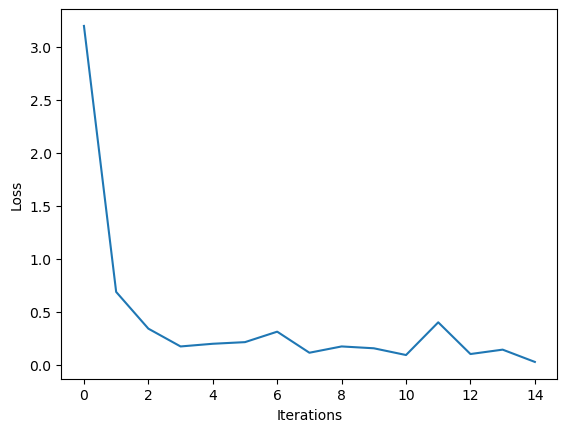

In [37]:
# You should be able to get a train accuracy of >90% and a test accuracy >85% 
# The settings below gave >95% train accuracy and >90% test accuracy 

# Feel free to adjust the values and explore how the network behaves
net_dims = [784, 100, 100, 64, 10] # This network has 4 layers
#784 is for image dimensions
#10 is for number of categories 
#100 and 64 are arbitrary

# list of dropout probabilities for each layer
# The length of the list is equal to the number of layers
# Note: Has to be same length as net_dims. 0 indicates no dropout
drop_prob_list = [0, 0, 0, 0]

# binary list indicating if batchnorm should be implemented for a layer
# The length of the list is equal to the number of layers
# 1 indicates bathnorm and 0 indicates no batchnorm
# If your implementation of batchnorm is incorrect, then set bnorm_list = [0,0,0,0]
bnorm_list = [1,1,1,1]
assert(len(bnorm_list) == len(net_dims)-1)

# list of strings indicating the activation for a layer
# The length of the list is equal to the number of layers
# The last layer is usually a linear before the softmax
act_list = ['relu', 'relu', 'relu', 'linear']
assert(len(act_list) == len(net_dims)-1)
    
# initialize learning rate, decay_rate and num_iterations 
num_epochs = 3
batch_size = 64
learning_rate = 1e-2
decay_rate = 1
apply_momentum = True

np.random.seed(1)

print("Network dimensions are:" + str(net_dims))
print('Dropout= [{}], Batch Size = {}, lr = {}, decay rate = {}'\
      .format(drop_prob_list,batch_size,learning_rate,decay_rate)) 

# getting the subset dataset from MNIST
trX, trY, tsX, tsY = get_mnist()
# We need to reshape the data everytime to match the format (d,m), where d is dimensions (784) and m is number of samples
trX = trX.reshape(-1, 28*28).T
trY = trY.reshape(1, -1)
tsX = tsX.reshape(-1, 28*28).T
tsY = tsY.reshape(1, -1)

costs, parameters = multi_layer_network(trX, trY, net_dims, act_list, drop_prob_list, bnorm_list, \
                                        num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate, \
                                        decay_rate=decay_rate, apply_momentum=apply_momentum, log=True)

# compute the accuracy for training set and testing set
train_Pred = classify(trX, parameters)

test_Pred = classify(tsX, parameters)

# Estimate the training accuracy 'trAcc' comparing train_Pred and trY 
# Estimate the testing accuracy 'teAcc' comparing test_Pred and tsY
# your code here

trAcc = sum([p == y for p, y in zip(train_Pred[0], trY[0])]) / len(train_Pred[0]) * 100 
teAcc = sum([p == y for p, y in zip(test_Pred[0], tsY[0])]) / len(test_Pred[0]) * 100

print("Accuracy for training set is {0:0.3f} %".format(trAcc))
print("Accuracy for testing set is {0:0.3f} %".format(teAcc))

plt.plot(range(len(costs)),costs)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()


# Don't edit the below code.
with open('/usercode/trained_model.pkl','wb') as f:
    pickle.dump(parameters,f)